In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import seaborn as sns
from scipy.interpolate import griddata
from skimage import measure
import cv2
from tqdm import tqdm
import h5py

In [2]:
font_path = 'C:/Windows/Fonts/malgun.ttf'
fontprop = fm.FontProperties(fname=font_path, size=18)

In [3]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.externals import joblib

C:\Users\bigBro\AppData\Roaming\Python\Python37\site-packages\sklearn\externals\joblib\__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


# 통합 데이터 생성

## 데이터 수집

#### 사용 데이터

In [15]:
selected_col = ['지점', '일시', '기온', '풍향', '풍속', '강수량', '습도', '현지기압', '해면기압', '전운량', '중하층운량', '최저운고']

### Data Load

#### 2019

In [3]:
df_asos_2019 = pd.read_csv('./data/asos_2019.csv')
df_aws_2019 = pd.read_csv('./data/aws_2019.csv')
df_asos_2019.shape, df_aws_2019.shape

C:\Users\bigBro\Anaconda3\envs\powerplant\lib\site-packages\IPython\core\interactiveshell.py:3057: DtypeWarning: Columns (26) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
df_all_2019 = pd.concat([df_asos_2019, df_aws_2019]).drop('Unnamed: 0', axis=1)

((528691, 37), (2501036, 10))

#### 2018

In [6]:
df_asos_2018 = pd.read_csv('./data/asos_2018.csv')
df_aws_2018 = pd.read_csv('./data/aws_2018.csv')
df_asos_2018.shape, df_aws_2018.shape

In [8]:
df_all_2018 = pd.concat([df_asos_2018, df_aws_2018]).drop('Unnamed: 0', axis=1)

C:\Users\bigBro\Anaconda3\envs\powerplant\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


#### 2017

In [11]:
df_asos_2017 = pd.read_csv('./data/asos_2017.csv')
df_aws_2017 = pd.read_csv('./data/aws_2017.csv')
df_asos_2017.shape, df_aws_2017.shape

In [13]:
df_all_2017 = pd.concat([df_asos_2017, df_aws_2017]).drop('Unnamed: 0', axis=1)

C:\Users\bigBro\Anaconda3\envs\powerplant\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


#### 통합

In [16]:
df_weather = pd.concat([df_all_2017, df_all_2018, df_all_2019]).drop('Unnamed: 0', axis=1)
df_weather['일시'] = pd.to_datetime(df_weather['일시'])

C:\Users\bigBro\Anaconda3\envs\powerplant\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


In [20]:
df_weather.columns

Index(['10cm 지중온도(°C)', '20cm 지중온도(°C)', '30cm 지중온도(°C)', '3시간신적설(cm)',
       '5cm 지중온도(°C)', '강수량', '강수량 QC플래그', '기온', '기온 QC플래그', '습도', '습도 QC플래그',
       '시정(10m)', '운형', '운형(운형약어)', '이슬점온도', '일사(MJ/m2)', '일시', '일조',
       '일조 QC플래그', '일조(hr)', '적설(cm)', '전운량', '중하층운량', '증기압', '지면상태(지면상태코드)',
       '지면온도 QC플래그', '지면온도(°C)', '지점', '최저운고', '풍속', '풍속 QC플래그', '풍향',
       '풍향 QC플래그', '해면기압', '해면기압 QC플래그', '현상번호(국내식)', '현지기압', '현지기압 QC플래그'],
      dtype='object')

#### 사용 속성 선택

In [38]:
df_weather = df_weather[selected_col]

#### 좌표 변환

In [36]:
df_asos = pd.read_csv('./data/asos_kma.csv').drop('Unnamed: 0', axis=1)
df_aws = pd.read_csv('./data/aws_kma.csv')
df_coord = pd.concat([df_asos, df_aws])

In [39]:
df_weather = pd.merge(df_weather, df_coord[['지점','fixed_la', 'fixed_lo']])

#### 데이터 저장

In [40]:
df_weather.to_csv('./data/total_weather.csv')

#### 데이터 로드

In [200]:
df_weather = pd.read_csv('./data/total_weather.csv').drop('Unnamed: 0', axis=1)
df_weather['일시'] = pd.to_datetime(df_weather['일시'])
df_weather.head()

,지점,일시,기온,풍향,풍속,강수량,습도,현지기압,해면기압,전운량,중하층운량,최저운고,fixed_la,fixed_lo
0,90,2017-07-01 00:00:00,26.9,320.0,1.0,NaN,51.0,1002.4,1004.4,NaN,NaN,NaN,87,142
1,90,2017-07-01 01:00:00,26.5,360.0,1.4,NaN,53.0,1002.1,1004.1,NaN,NaN,NaN,87,142
2,90,2017-07-01 02:00:00,26.4,340.0,2.1,NaN,56.0,1001.9,1003.9,NaN,NaN,NaN,87,142
3,90,2017-07-01 03:00:00,28.1,270.0,2.6,NaN,52.0,1001.1,1003.1,NaN,NaN,NaN,87,142
4,90,2017-07-01 04:00:00,26.3,290.0,1.1,NaN,60.0,1001.5,1003.5,NaN,NaN,NaN,87,142


## 전처리

### 선형보간
> 기온: linear <br>
풍향: nearest : 0과 360이 같은 값이므로 linear 사용시 문제 발생 가능성 존재<br>
풍속: linear <br>
강수량: linear 선형적인거 같기도 하고, 아닌거 같기도 하고...<br>
습도: linear <br>
현지기압: linear <br>
해면기압: linear <br>
전운량: linear <br>
중하층운량: linear <br>
최저운고: linear <br>

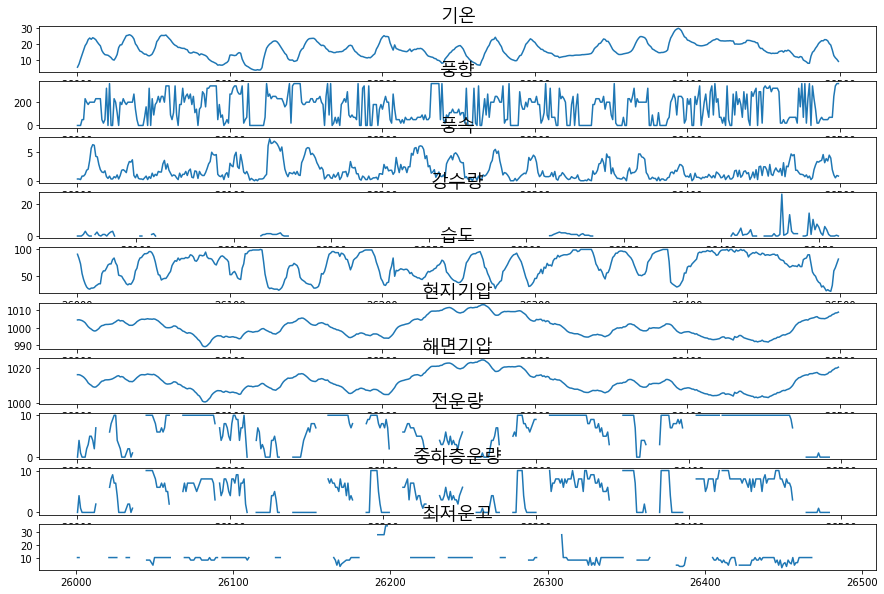

In [161]:
plt.figure(figsize=(15,10))
for i, f in zip(range(1,11), selected_col[2:]):
    ax = plt.subplot(10, 1, i)
    ax.set_title(f, fontproperties=fontprop)
    ax.plot(df_weather[f][26000:26500])

#### 강수량은 linear가 적합

In [130]:
test_point['강수량'].isnull().sum()

16808

In [132]:
test_point['강수량'].interpolate(inplace=True)
test_point['강수량'].isnull().sum()

29

In [128]:
test_point['강수량'][568455]

35.4

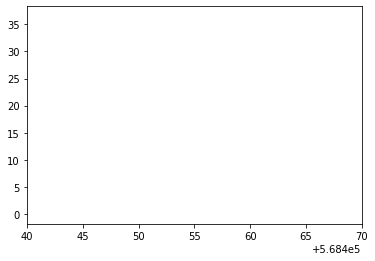

In [96]:
plt.xlim(568440,568470)
plt.plot(test_point['강수량'])

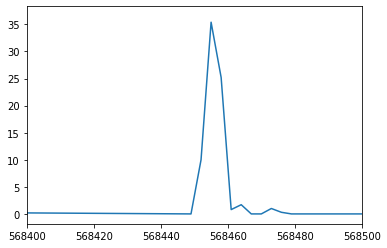

In [123]:
plt.xlim(568400,568500)
plt.plot(test_point['강수량'].interpolate(mathod='nearest'))

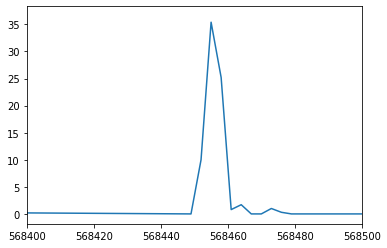

In [122]:
plt.xlim(568400,568500)
plt.plot(test_point['강수량'].interpolate(mathod='linear'))

In [25]:
points = df_weather['지점'].unique()

In [201]:
df_resampled_weather = pd.DataFrame(columns=selected_col)
for point in tqdm(points):
    one_point = df_weather[df_weather['지점']==point].interpolate(mathod='linear')
    one_point['풍향'].interpolate(method='nearest', inplace=True)
    one_point[['기온', '풍속', '강수량', '습도', '현지기압', '해면기압', '전운량', '중하층운량', '최저운고']].interpolate(method='linear', inplace=True)
    df_resampled_weather = pd.concat([df_resampled_weather, one_point])





  0%|                                                                                          | 0/598 [00:00<?, ?it/s]C:\Users\bigBro\Anaconda3\envs\powerplant\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
C:\Users\bigBro\Anaconda3\envs\powerplant\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  




  0%|▏                                                                                 | 1/598 [00:00<06:15,  1.59it/s]



  0%|▎                                                                                 | 2/598 [0

### 보간 결과

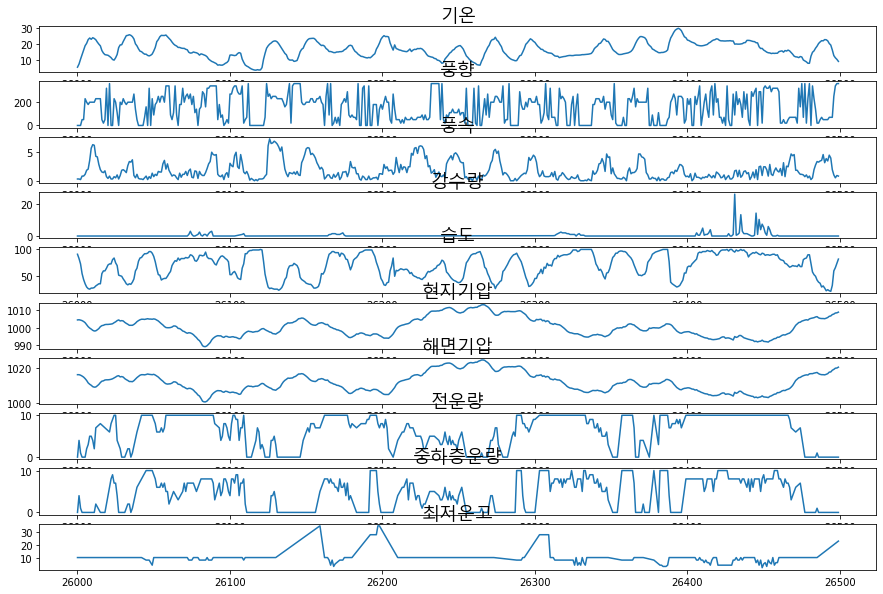

In [202]:
plt.figure(figsize=(15,10))
for i, f in zip(range(1,11), selected_col[2:]):
    ax = plt.subplot(10, 1, i)
    ax.set_title(f, fontproperties=fontprop)
    ax.plot(df_resampled_weather[f][26000:26500])

In [203]:
df_resampled_weather.to_csv('./data/total_weather_resampled.csv')

#### Data Load

In [37]:
df_resampled_weather = pd.read_csv('./data/total_weather_resampled.csv')
df_resampled_weather['일시'] = pd.to_datetime(df_resampled_weather['일시'])

### Scaling (Robust)

In [27]:
sc = RobustScaler()

In [28]:
sc.fit(df_resampled_weather[selected_col[2:]])
df_resampled_weather[selected_col[2:]] = sc.transform(df_resampled_weather[selected_col[2:]])

#### Scaler 저장

In [29]:
joblib.dump(sc, './data/scaler.pkl')

['./data/scaler.pkl']

In [30]:
sc = joblib.load('./data/scaler.pkl')

In [31]:
times = pd.date_range(min(df_resampled_weather['일시']), pd.Timestamp('2019-07-01T00'), freq='H')

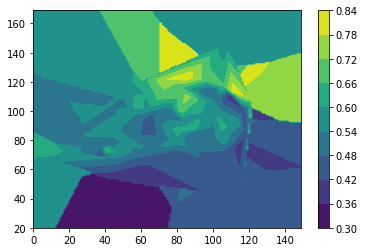

In [32]:
test_info = df_resampled_weather[df_resampled_weather['일시']==times[0]]
xi, yi = np.meshgrid(np.arange(0, 150, 1), np.arange(20, 170, 1))
zi = griddata((test_info['fixed_la'].values, test_info['fixed_lo'].values), test_info['기온'].values, (xi, yi),method='linear')
mask_zi = griddata((test_info['fixed_la'].values, test_info['fixed_lo'].values), test_info['기온'].values, (xi, yi),method='nearest')
zi[np.isnan(zi)] = mask_zi[np.isnan(zi)]
zi[np.isnan(zi)] = np.nanmean(zi)
cb = plt.contourf(xi, yi, zi.T)
plt.colorbar(cb)
plt.show(cb)

In [33]:
times[0], times[-1], len(times)

(Timestamp('2017-07-01 00:00:00', freq='H'),
 Timestamp('2019-07-01 00:00:00', freq='H'),
 17521)

### 데이터셋 생성
### 이미지 생성 -> 다운스케일 하였음
### 다운스케일 -> 이미지 생성도 해볼 필요 있음

In [256]:
data = np.zeros((len(times), 10, 75, 75))
for time, i in tqdm(zip(times, range(len(times)))):
    images = np.zeros((10, 75, 75))
    test_info = df_resampled_weather[df_resampled_weather['일시']==time]
    
    for ft, j in zip(selected_col[2:], range(10)):
        xi, yi = np.meshgrid(np.arange(0, 150, 1), np.arange(20, 170, 1))
        zi = griddata((test_info['fixed_la'].values, test_info['fixed_lo'].values), test_info[ft].values, (xi, yi), method='linear')
        mask_zi = griddata((test_info['fixed_la'].values, test_info['fixed_lo'].values), test_info[ft].values, (xi, yi), method='nearest')
        zi[np.isnan(zi)] = mask_zi[np.isnan(zi)]
        zi[np.isnan(zi)] = np.nanmean(zi)
        images[j] = cv2.resize(zi, dsize=(75, 75), interpolation=cv2.INTER_NEAREST)
        
    data[i] = images[:,:]






0it [00:00, ?it/s]




1it [00:00,  3.98it/s]




2it [00:00,  3.15it/s]




3it [00:01,  2.74it/s]




4it [00:01,  2.52it/s]




5it [00:02,  2.37it/s]




6it [00:02,  2.29it/s]




7it [00:03,  2.23it/s]




8it [00:03,  2.19it/s]




9it [00:04,  2.16it/s]




10it [00:04,  2.14it/s]




11it [00:05,  2.13it/s]




12it [00:05,  2.12it/s]




13it [00:05,  2.12it/s]




14it [00:06,  2.12it/s]




15it [00:06,  2.11it/s]




16it [00:07,  2.11it/s]




17it [00:07,  2.11it/s]




18it [00:08,  2.11it/s]




19it [00:08,  2.11it/s]




20it [00:09,  2.10it/s]




21it [00:09,  2.10it/s]




22it [00:10,  2.11it/s]




23it [00:10,  2.10it/s]




24it [00:11,  2.10it/s]




25it [00:11,  2.11it/s]




26it [00:12,  2.11it/s]




27it [00:12,  2.10it/s]




28it [00:13,  2.11it/s]




29it [00:13,  2.12it/s]




30it [00:14,  2.12it/s]




31it [00:14,  2.11it/s]




32it [00:14,  2.12it/s]




33it [00:15,  2.12it/s]




34it [00:15,  2.11it/s]




35it [00:16,  2.11it/s]




3

In [3]:
wind_gen = pd.read_csv('./data/wind_gen.csv').drop('Unnamed: 0', axis=1)
wind_gen['일시'] = pd.to_datetime(wind_gen['일시'])

In [259]:
df_resampled_weather.head()

,fixed_la,fixed_lo,강수량,기온,습도,일시,전운량,중하층운량,지점,최저운고,풍속,풍향,해면기압,현지기압
0,87.0,142.0,NaN,0.731429,-0.650000,2017-07-01 00:00:00,NaN,NaN,90,NaN,-0.285714,0.653199,-0.866667,-0.180905
1,87.0,142.0,NaN,0.708571,-0.594444,2017-07-01 01:00:00,NaN,NaN,90,NaN,-0.095238,0.821549,-0.888889,-0.195980
2,87.0,142.0,NaN,0.702857,-0.511111,2017-07-01 02:00:00,NaN,NaN,90,NaN,0.238095,0.737374,-0.903704,-0.206030
3,87.0,142.0,NaN,0.800000,-0.622222,2017-07-01 03:00:00,NaN,NaN,90,NaN,0.476190,0.442761,-0.962963,-0.246231
4,87.0,142.0,NaN,0.697143,-0.400000,2017-07-01 04:00:00,NaN,NaN,90,NaN,-0.238095,0.526936,-0.933333,-0.226131


In [35]:
wind_gen.head()

,일시,발전량
0,2017-07-01 01:00:00,1.09776
1,2017-07-01 02:00:00,1.38600
2,2017-07-01 03:00:00,0.54600
3,2017-07-01 04:00:00,0.00000
4,2017-07-01 05:00:00,7.16832


#### 2017년 저장

In [347]:
len(pd.date_range(pd.Timestamp('2017-07-01T00'), pd.Timestamp('2017-12-31T23'), freq='H'))

4416

In [348]:
len(wind_gen.iloc[:4416])

4416

In [349]:
data[:4416].shape

(4416, 10, 75, 75)

In [36]:
wind_2017 = wind_gen[wind_gen['일시'] <= pd.Timestamp('2018-01-01T00')]
len(wind_2017['발전량'].values)

4416

In [351]:
wind_2017.shape

(4416, 2)

In [352]:
h5f = h5py.File('D:/total_data.h5', 'w')

In [353]:
h5f.create_dataset('total_2017', data=data[:4416])
h5f.create_dataset('gen_2017', data=wind_2017['발전량'].values)
#h5f.close()

<HDF5 dataset "gen_2017": shape (4416,), type "<f8">

#### 2018년 저장

In [354]:
len(pd.date_range(pd.Timestamp('2018-01-01T00'), pd.Timestamp('2018-12-31T23'), freq='H'))

8760

In [355]:
len(wind_gen.iloc[4416:13176])

8760

In [356]:
data[4416:13176].shape

(8760, 10, 75, 75)

In [357]:
wind_2018['발전량'].shape

(8760,)

In [358]:
wind_2018 = wind_gen[(wind_gen['일시'] > pd.Timestamp('2018-01-01T00')) & (wind_gen['일시'] <= pd.Timestamp('2019-01-01T00'))]
len(wind_2018['발전량'].values)

8760

In [359]:
h5f.create_dataset('total_2018', data=data[4416:13176])
h5f.create_dataset('gen_2018', data=wind_2018['발전량'].values)
#h5f.close()

<HDF5 dataset "gen_2018": shape (8760,), type "<f8">

#### 2019년 저장

In [360]:
len(pd.date_range(pd.Timestamp('2019-01-01T00'), pd.Timestamp('2019-06-30T23'), freq='H'))

4344

In [361]:
len(wind_gen.iloc[13176:])

4344

In [362]:
wind_2019 = wind_gen.iloc[13176:]
len(wind_2019)

4344

In [363]:
data[13176:17520].shape

(4344, 10, 75, 75)

In [364]:
h5f.create_dataset('total_2019', data=data[13176:17520])
h5f.create_dataset('gen_2019', data=wind_2019['발전량'].values)
h5f.close()

In [37]:
h5f = h5py.File('./data/data_2018.h5','r')

In [38]:
data = h5f['total_2018'][:]
gen_data = h5f['gen_2018'][:]
h5f.close()

In [39]:
data.shape, gen_data.shape

((8760, 7, 75, 75), (8760,))

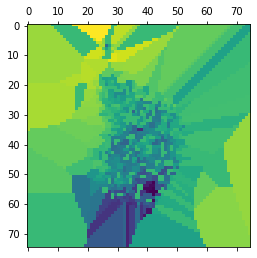

In [28]:
plt.matshow(data[0,0,:,:])

# 2017

### Data Load

### 좌표 변환

In [34]:
df_feature_2017 = df_all_2017[['지점', '일시', '기온', '풍향', '풍속', '강수량', '습도', '현지기압', '해면기압']]

In [35]:
df_feature_2017 = pd.merge(df_feature_2017, df_coord[['지점','fixed_la', 'fixed_lo']])

In [36]:
times = pd.date_range(min(df_feature_2017['일시']), max(df_feature_2017['일시']), freq='H')
data = np.zeros((len(times), 7, 75, 75))

In [37]:
times[0], times[-1], len(times)

(Timestamp('2017-07-01 00:00:00', freq='H'),
 Timestamp('2018-01-01 00:00:00', freq='H'),
 4417)

In [38]:
sc = RobustScaler()

In [39]:
df_feature_2017[['기온', '풍향', '풍속', '강수량', '습도', '현지기압', '해면기압']] = sc.fit_transform(df_feature_2017[['기온', '풍향', '풍속', '강수량', '습도', '현지기압', '해면기압']])

In [40]:
for time, i in tqdm(zip(times, range(len(times)))):
    images = np.zeros((7, 75, 75))
    test_info = df_feature_2017[df_feature_2017['일시']==time]
    
    # 기온
    xi, yi = np.meshgrid(np.arange(0, 150, 1), np.arange(20, 170, 1))
    zi = griddata((test_info['fixed_la'].values, test_info['fixed_lo'].values), test_info['기온'].values, (xi, yi),method='cubic')
    mask_zi = griddata((test_info['fixed_la'].values, test_info['fixed_lo'].values), test_info['기온'].values, (xi, yi),method='nearest')
    zi[np.isnan(zi)] = mask_zi[np.isnan(zi)]
    zi[np.isnan(zi)] = np.nanmean(zi)
    images[0] = cv2.resize(zi, dsize=(75, 75), interpolation=cv2.INTER_NEAREST)
    
    # 풍향
    xi, yi = np.meshgrid(np.arange(0, 150, 1), np.arange(20, 170, 1))
    zi = griddata((test_info['fixed_la'].values, test_info['fixed_lo'].values), test_info['풍향'].values, (xi, yi),method='cubic')
    mask_zi = griddata((test_info['fixed_la'].values, test_info['fixed_lo'].values), test_info['풍향'].values, (xi, yi),method='nearest')
    zi[np.isnan(zi)] = mask_zi[np.isnan(zi)]
    zi[np.isnan(zi)] = np.nanmean(zi)
    images[1] = cv2.resize(zi, dsize=(75, 75), interpolation=cv2.INTER_NEAREST)    
    
    # 풍속
    xi, yi = np.meshgrid(np.arange(0, 150, 1), np.arange(20, 170, 1))
    zi = griddata((test_info['fixed_la'].values, test_info['fixed_lo'].values), test_info['풍속'].values, (xi, yi),method='linear')
    mask_zi = griddata((test_info['fixed_la'].values, test_info['fixed_lo'].values), test_info['풍속'].values, (xi, yi),method='nearest')
    zi[np.isnan(zi)] = mask_zi[np.isnan(zi)]
    zi[np.isnan(zi)] = np.nanmean(zi)
    images[2] = cv2.resize(zi, dsize=(75, 75), interpolation=cv2.INTER_NEAREST)    
    
    # 강수량
    xi, yi = np.meshgrid(np.arange(0, 150, 1), np.arange(20, 170, 1))
    zi = griddata((test_info['fixed_la'].values, test_info['fixed_lo'].values), test_info['강수량'].values, (xi, yi),method='nearest')
    mask_zi = griddata((test_info['fixed_la'].values, test_info['fixed_lo'].values), test_info['강수량'].values, (xi, yi),method='nearest')
    zi[np.isnan(zi)] = mask_zi[np.isnan(zi)]
    zi[np.isnan(zi)] = np.nanmean(zi)
    images[3] = cv2.resize(zi, dsize=(75, 75), interpolation=cv2.INTER_NEAREST)    
    
    # 습도
    xi, yi = np.meshgrid(np.arange(0, 150, 1), np.arange(20, 170, 1))
    zi = griddata((test_info['fixed_la'].values, test_info['fixed_lo'].values), test_info['습도'].values, (xi, yi),method='linear')
    mask_zi = griddata((test_info['fixed_la'].values, test_info['fixed_lo'].values), test_info['습도'].values, (xi, yi),method='nearest')
    zi[np.isnan(zi)] = mask_zi[np.isnan(zi)]
    zi[np.isnan(zi)] = np.nanmean(zi)
    images[4] = cv2.resize(zi, dsize=(75, 75), interpolation=cv2.INTER_NEAREST)    
    
    # 현지기압
    xi, yi = np.meshgrid(np.arange(0, 150, 1), np.arange(20, 170, 1))
    zi = griddata((test_info['fixed_la'].values, test_info['fixed_lo'].values), test_info['현지기압'].values, (xi, yi),method='cubic')
    mask_zi = griddata((test_info['fixed_la'].values, test_info['fixed_lo'].values), test_info['현지기압'].values, (xi, yi),method='nearest')
    zi[np.isnan(zi)] = mask_zi[np.isnan(zi)]
    zi[np.isnan(zi)] = np.nanmean(zi)
    images[5] = cv2.resize(zi, dsize=(75, 75), interpolation=cv2.INTER_NEAREST)    
  
    # 해면기압
    xi, yi = np.meshgrid(np.arange(0, 150, 1), np.arange(20, 170, 1))
    zi = griddata((test_info['fixed_la'].values, test_info['fixed_lo'].values), test_info['해면기압'].values, (xi, yi),method='cubic')
    mask_zi = griddata((test_info['fixed_la'].values, test_info['fixed_lo'].values), test_info['해면기압'].values, (xi, yi),method='nearest')
    zi[np.isnan(zi)] = mask_zi[np.isnan(zi)]
    zi[np.isnan(zi)] = np.nanmean(zi)
    images[6] = cv2.resize(zi, dsize=(75, 75), interpolation=cv2.INTER_NEAREST)    
    
    data[i] = images[:,:]

0it [00:00, ?it/s]C:\Users\bigBro\Anaconda3\envs\powerplant\lib\site-packages\ipykernel_launcher.py:42: RuntimeWarning: Mean of empty slice
4417it [23:46,  3.08it/s]


In [41]:
wind_gen = pd.read_csv('./data/wind_gen.csv').drop('Unnamed: 0', axis=1)
wind_gen['일시'] = pd.to_datetime(wind_gen['일시'])

In [42]:
wind_gen.head()

,일시,발전량
0,2017-07-01 01:00:00,1.09776
1,2017-07-01 02:00:00,1.38600
2,2017-07-01 03:00:00,0.54600
3,2017-07-01 04:00:00,0.00000
4,2017-07-01 05:00:00,7.16832


In [43]:
wind_2017 = wind_gen[wind_gen['일시'] <= pd.Timestamp('2018-01-01T01')]

In [44]:
len(wind_2017['발전량'].values)

4417

In [45]:
h5f = h5py.File('./data/data_2017.h5', 'w')

In [46]:
h5f.create_dataset('total_2017', data=data)
h5f.create_dataset('gen_2017', data=wind_2017['발전량'].values)
h5f.close()

# 2019

### Data Load

In [78]:
df_all_2019 = df_all_2019.drop('Unnamed: 0', axis=1)

In [79]:
df_all_2019['일시'] = pd.to_datetime(df_all_2019['일시'])

### 좌표 변환

In [80]:
df_feature_2019 = df_all_2019[['지점', '일시', '기온', '풍향', '풍속', '강수량', '습도', '현지기압', '해면기압']]

In [81]:
df_feature_2019 = pd.merge(df_feature_2019, df_coord[['지점','fixed_la', 'fixed_lo']])

In [82]:
times = pd.date_range(min(df_feature_2019['일시']), max(df_feature_2019['일시']), freq='H')
data = np.zeros((len(times), 7, 75, 75))

In [83]:
times[0], times[-1], len(times)

(Timestamp('2019-01-01 01:00:00', freq='H'),
 Timestamp('2019-08-21 00:00:00', freq='H'),
 5568)

In [84]:
sc = RobustScaler()

In [85]:
times = pd.date_range(min(df_feature_2019['일시']), pd.Timestamp('2019-07-01T00'), freq='H')
data = np.zeros((len(times), 7, 75, 75))

In [86]:
times[0], times[-1], len(times)

(Timestamp('2019-01-01 01:00:00', freq='H'),
 Timestamp('2019-07-01 00:00:00', freq='H'),
 4344)

In [87]:
df_feature_2019[['기온', '풍향', '풍속', '강수량', '습도', '현지기압', '해면기압']] = sc.fit_transform(df_feature_2019[['기온', '풍향', '풍속', '강수량', '습도', '현지기압', '해면기압']])

In [88]:
for time, i in tqdm(zip(times, range(len(times)))):
    images = np.zeros((7, 75, 75))
    test_info = df_feature_2019[df_feature_2019['일시']==time]
    
    # 기온
    xi, yi = np.meshgrid(np.arange(0, 150, 1), np.arange(20, 170, 1))
    zi = griddata((test_info['fixed_la'].values, test_info['fixed_lo'].values), test_info['기온'].values, (xi, yi),method='cubic')
    mask_zi = griddata((test_info['fixed_la'].values, test_info['fixed_lo'].values), test_info['기온'].values, (xi, yi),method='nearest')
    zi[np.isnan(zi)] = mask_zi[np.isnan(zi)]
    zi[np.isnan(zi)] = np.nanmean(zi)
    images[0] = cv2.resize(zi, dsize=(75, 75), interpolation=cv2.INTER_NEAREST)
    
    # 풍향
    xi, yi = np.meshgrid(np.arange(0, 150, 1), np.arange(20, 170, 1))
    zi = griddata((test_info['fixed_la'].values, test_info['fixed_lo'].values), test_info['풍향'].values, (xi, yi),method='cubic')
    mask_zi = griddata((test_info['fixed_la'].values, test_info['fixed_lo'].values), test_info['풍향'].values, (xi, yi),method='nearest')
    zi[np.isnan(zi)] = mask_zi[np.isnan(zi)]
    zi[np.isnan(zi)] = np.nanmean(zi)
    images[1] = cv2.resize(zi, dsize=(75, 75), interpolation=cv2.INTER_NEAREST)    
    
    # 풍속
    xi, yi = np.meshgrid(np.arange(0, 150, 1), np.arange(20, 170, 1))
    zi = griddata((test_info['fixed_la'].values, test_info['fixed_lo'].values), test_info['풍속'].values, (xi, yi),method='linear')
    mask_zi = griddata((test_info['fixed_la'].values, test_info['fixed_lo'].values), test_info['풍속'].values, (xi, yi),method='nearest')
    zi[np.isnan(zi)] = mask_zi[np.isnan(zi)]
    zi[np.isnan(zi)] = np.nanmean(zi)
    images[2] = cv2.resize(zi, dsize=(75, 75), interpolation=cv2.INTER_NEAREST)    
    
    # 강수량
    xi, yi = np.meshgrid(np.arange(0, 150, 1), np.arange(20, 170, 1))
    zi = griddata((test_info['fixed_la'].values, test_info['fixed_lo'].values), test_info['강수량'].values, (xi, yi),method='nearest')
    mask_zi = griddata((test_info['fixed_la'].values, test_info['fixed_lo'].values), test_info['강수량'].values, (xi, yi),method='nearest')
    zi[np.isnan(zi)] = mask_zi[np.isnan(zi)]
    zi[np.isnan(zi)] = np.nanmean(zi)
    images[3] = cv2.resize(zi, dsize=(75, 75), interpolation=cv2.INTER_NEAREST)    
    
    # 습도
    xi, yi = np.meshgrid(np.arange(0, 150, 1), np.arange(20, 170, 1))
    zi = griddata((test_info['fixed_la'].values, test_info['fixed_lo'].values), test_info['습도'].values, (xi, yi),method='linear')
    mask_zi = griddata((test_info['fixed_la'].values, test_info['fixed_lo'].values), test_info['습도'].values, (xi, yi),method='nearest')
    zi[np.isnan(zi)] = mask_zi[np.isnan(zi)]
    zi[np.isnan(zi)] = np.nanmean(zi)
    images[4] = cv2.resize(zi, dsize=(75, 75), interpolation=cv2.INTER_NEAREST)    
    
    # 현지기압
    xi, yi = np.meshgrid(np.arange(0, 150, 1), np.arange(20, 170, 1))
    zi = griddata((test_info['fixed_la'].values, test_info['fixed_lo'].values), test_info['현지기압'].values, (xi, yi),method='cubic')
    mask_zi = griddata((test_info['fixed_la'].values, test_info['fixed_lo'].values), test_info['현지기압'].values, (xi, yi),method='nearest')
    zi[np.isnan(zi)] = mask_zi[np.isnan(zi)]
    zi[np.isnan(zi)] = np.nanmean(zi)
    images[5] = cv2.resize(zi, dsize=(75, 75), interpolation=cv2.INTER_NEAREST)    
  
    # 해면기압
    xi, yi = np.meshgrid(np.arange(0, 150, 1), np.arange(20, 170, 1))
    zi = griddata((test_info['fixed_la'].values, test_info['fixed_lo'].values), test_info['해면기압'].values, (xi, yi),method='cubic')
    mask_zi = griddata((test_info['fixed_la'].values, test_info['fixed_lo'].values), test_info['해면기압'].values, (xi, yi),method='nearest')
    zi[np.isnan(zi)] = mask_zi[np.isnan(zi)]
    zi[np.isnan(zi)] = np.nanmean(zi)
    images[6] = cv2.resize(zi, dsize=(75, 75), interpolation=cv2.INTER_NEAREST) 
    
    data[i] = images[:,:]

4344it [23:22,  3.08it/s]


In [92]:
data = data[:-1]

In [93]:
data.shape

(4343, 7, 75, 75)

In [89]:
wind_gen = pd.read_csv('./data/wind_gen.csv').drop('Unnamed: 0', axis=1)
wind_gen['일시'] = pd.to_datetime(wind_gen['일시'])

In [90]:
wind_2019 = wind_gen[(wind_gen['일시'] > pd.Timestamp('2019-01-01T01')) & (wind_gen['일시'] <= pd.Timestamp('2019-07-01T01'))]
len(wind_2019['발전량'].values)

In [94]:
wind_2019.head()

,일시,발전량
13177,2019-01-01 02:00:00,16.07928
13178,2019-01-01 03:00:00,14.51448
13179,2019-01-01 04:00:00,17.10600
13180,2019-01-01 05:00:00,23.82240
13181,2019-01-01 06:00:00,30.91200


In [95]:
h5f = h5py.File('./data/data_2019.h5', 'w')

In [96]:
h5f.create_dataset('total_2019', data=data)
h5f.create_dataset('gen_2019', data=wind_2019['발전량'].values)
h5f.close()

#### MinMax Scaler

#### Data Load

In [38]:
df_resampled_weather = pd.read_csv('./data/total_weather_resampled.csv').drop('Unnamed: 0', axis=1)
df_resampled_weather['일시'] = pd.to_datetime(df_resampled_weather['일시'])

In [39]:
sc = MinMaxScaler()

In [40]:
sc.fit(df_resampled_weather[selected_col[2:]])
df_resampled_weather[selected_col[2:]] = sc.transform(df_resampled_weather[selected_col[2:]])

#### Scaler 저장

In [41]:
joblib.dump(sc, './data/scaler_mm.pkl')

['./data/scaler_mm.pkl']

In [30]:
sc = joblib.load('./data/scaler_mm.pkl')

In [42]:
times = pd.date_range(min(df_resampled_weather['일시']), pd.Timestamp('2019-07-01T00'), freq='H')

In [58]:
times[-1]

Timestamp('2019-07-01 00:00:00', freq='H')

In [59]:
wind_gen.tail()

,일시,발전량
17515,2019-06-30 20:00:00,0.53136
17516,2019-06-30 21:00:00,1.27584
17517,2019-06-30 22:00:00,0.00000
17518,2019-06-30 23:00:00,0.00000
17519,2019-07-01 00:00:00,0.00000


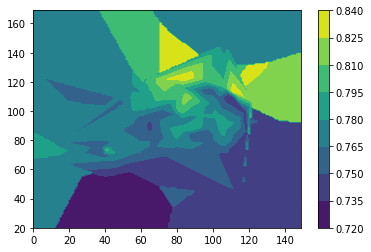

In [43]:
test_info = df_resampled_weather[df_resampled_weather['일시']==times[0]]
xi, yi = np.meshgrid(np.arange(0, 150, 1), np.arange(20, 170, 1))
zi = griddata((test_info['fixed_la'].values, test_info['fixed_lo'].values), test_info['기온'].values, (xi, yi),method='linear')
mask_zi = griddata((test_info['fixed_la'].values, test_info['fixed_lo'].values), test_info['기온'].values, (xi, yi),method='nearest')
zi[np.isnan(zi)] = mask_zi[np.isnan(zi)]
zi[np.isnan(zi)] = np.nanmean(zi)
cb = plt.contourf(xi, yi, zi.T)
plt.colorbar(cb)
plt.show(cb)

In [68]:
times[0], times[-1], len(times)

(Timestamp('2017-07-01 00:00:00', freq='H'),
 Timestamp('2019-07-01 00:00:00', freq='H'),
 17521)

### 데이터셋 생성
### 이미지 생성 -> 다운스케일 하였음
### 다운스케일 -> 이미지 생성도 해볼 필요 있음

In [69]:
data = np.zeros((len(times), 10, 75, 75))
for time, i in tqdm(zip(times, range(len(times)))):
    images = np.zeros((10, 75, 75))
    test_info = df_resampled_weather[df_resampled_weather['일시']==time]
    
    for ft, j in zip(selected_col[2:], range(10)):
        xi, yi = np.meshgrid(np.arange(0, 150, 1), np.arange(20, 170, 1))
        zi = griddata((test_info['fixed_la'].values, test_info['fixed_lo'].values), test_info[ft].values, (xi, yi), method='linear')
        mask_zi = griddata((test_info['fixed_la'].values, test_info['fixed_lo'].values), test_info[ft].values, (xi, yi), method='nearest')
        zi[np.isnan(zi)] = mask_zi[np.isnan(zi)]
        zi[np.isnan(zi)] = np.nanmean(zi)
        images[j] = cv2.resize(zi, dsize=(75, 75), interpolation=cv2.INTER_NEAREST)
        
    data[i] = images[:,:]

17521it [2:16:05,  2.12it/s]


In [88]:
wind_gen = pd.read_csv('./data/wind_gen.csv').drop('Unnamed: 0', axis=1)
wind_gen['일시'] = pd.to_datetime(wind_gen['일시'])

## 발전량 정규화

#### Robust

In [91]:
sc = RobustScaler()

In [93]:
sc.fit(wind_gen[['발전량']])

RobustScaler(copy=True, quantile_range=(25.0, 75.0), with_centering=True,
             with_scaling=True)

In [94]:
wind_gen[['발전량']] = sc.transform(wind_gen[['발전량']])

In [96]:
joblib.dump(sc, './data/scaler_gen.pkl')

['./data/scaler_gen.pkl']

In [30]:
sc = joblib.load('./data/scaler.pkl')

In [95]:
wind_gen

,일시,발전량
0,2017-07-01 01:00:00,-0.246700
1,2017-07-01 02:00:00,-0.229772
2,2017-07-01 03:00:00,-0.279105
3,2017-07-01 04:00:00,-0.311171
4,2017-07-01 05:00:00,0.109822
5,2017-07-01 06:00:00,0.388004
6,2017-07-01 07:00:00,0.419083
7,2017-07-01 08:00:00,0.557554
8,2017-07-01 09:00:00,0.348354
9,2017-07-01 10:00:00,0.171319


In [89]:
df_resampled_weather.head()

,Unnamed: 0,fixed_la,fixed_lo,강수량,기온,습도,일시,전운량,중하층운량,지점,최저운고,풍속,풍향,해면기압,현지기압
0,0,87.0,142.0,NaN,0.814229,0.505051,2017-07-01 00:00:00,NaN,NaN,90,NaN,0.033003,0.888889,0.867971,0.914059
1,1,87.0,142.0,NaN,0.808959,0.525253,2017-07-01 01:00:00,NaN,NaN,90,NaN,0.046205,1.000000,0.867304,0.913358
2,2,87.0,142.0,NaN,0.807642,0.555556,2017-07-01 02:00:00,NaN,NaN,90,NaN,0.069307,0.944444,0.866859,0.912891
3,3,87.0,142.0,NaN,0.830040,0.515152,2017-07-01 03:00:00,NaN,NaN,90,NaN,0.085809,0.750000,0.865081,0.911023
4,4,87.0,142.0,NaN,0.806324,0.595960,2017-07-01 04:00:00,NaN,NaN,90,NaN,0.036304,0.805556,0.865970,0.911957


#### 2017년 저장

In [71]:
len(pd.date_range(pd.Timestamp('2017-07-01T00'), pd.Timestamp('2017-12-31T23'), freq='H'))

4416

In [72]:
len(wind_gen.iloc[:4416])

4416

In [73]:
data[:4416].shape

(4416, 10, 75, 75)

In [74]:
wind_2017 = wind_gen[wind_gen['일시'] <= pd.Timestamp('2018-01-01T00')]
len(wind_2017['발전량'].values)

4416

In [75]:
wind_2017.shape

(4416, 2)

In [76]:
h5f = h5py.File('D:/total_data.h5', 'w')

In [77]:
h5f.create_dataset('total_2017', data=data[:4416])
h5f.create_dataset('gen_2017', data=wind_2017['발전량'].values)
#h5f.close()

<HDF5 dataset "gen_2017": shape (4416,), type "<f8">

#### 2018년 저장

In [78]:
len(pd.date_range(pd.Timestamp('2018-01-01T00'), pd.Timestamp('2018-12-31T23'), freq='H'))

8760

In [79]:
len(wind_gen.iloc[4416:13176])

8760

In [80]:
data[4416:13176].shape

(8760, 10, 75, 75)

In [81]:
wind_2018 = wind_gen[(wind_gen['일시'] > pd.Timestamp('2018-01-01T00')) & (wind_gen['일시'] <= pd.Timestamp('2019-01-01T00'))]
len(wind_2018['발전량'].values)

8760

In [82]:
h5f.create_dataset('total_2018', data=data[4416:13176])
h5f.create_dataset('gen_2018', data=wind_2018['발전량'].values)
#h5f.close()

<HDF5 dataset "gen_2018": shape (8760,), type "<f8">

#### 2019년 저장

In [83]:
len(pd.date_range(pd.Timestamp('2019-01-01T00'), pd.Timestamp('2019-06-30T23'), freq='H'))

4344

In [84]:
len(wind_gen.iloc[13176:])

4344

In [85]:
wind_2019 = wind_gen.iloc[13176:]
len(wind_2019)

4344

In [86]:
data[13176:17520].shape

(4344, 10, 75, 75)

In [87]:
h5f.create_dataset('total_2019', data=data[13176:17520])
h5f.create_dataset('gen_2019', data=wind_2019['발전량'].values)
h5f.close()

In [37]:
h5f = h5py.File('./data/data_2018.h5','r')

In [38]:
data = h5f['total_2018'][:]
gen_data = h5f['gen_2018'][:]
h5f.close()

In [39]:
data.shape, gen_data.shape

((8760, 7, 75, 75), (8760,))

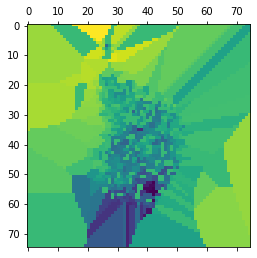

In [28]:
plt.matshow(data[0,0,:,:])

In [8]:
solar_gen = pd.read_csv('./data/solar_gen.csv', names=['일시', '시간', '발전량'])

In [10]:
solar_gen['일시'] = pd.to_datetime(solar_gen['일시'], format='%Y-%m-%d') + pd.to_timedelta(solar_gen['시간'], unit='h')
solar_gen = solar_gen.drop(['시간'], axis=1)
solar_gen['발전량'] = solar_gen['발전량'].replace(' - ', '0').astype('float32')

In [12]:
solar_gen.head()

,일시,발전량
0,2017-07-01 01:00:00,0.0
1,2017-07-01 02:00:00,0.0
2,2017-07-01 03:00:00,0.0
3,2017-07-01 04:00:00,0.0
4,2017-07-01 05:00:00,0.0


In [13]:
import h5py

In [42]:
h5f = h5py.File('D:/total_data_ro.h5')
gen_data_17 = h5f['gen_solar_2017'][:]
gen_data_18 = h5f['gen_solar_2018'][:]
gen_data_19 = h5f['gen_solar_2019'][:]
h5f.close()

In [43]:
gen_data_17.shape, gen_data_18.shape, gen_data_19.shape

((4416,), (8760,), (4344,))

In [23]:
solar_gen.shape

(17520, 2)

In [36]:
h5f = h5py.File('D:/total_data_ro.h5', 'a')
h5f['gen_solar_2017'] = solar_gen['발전량'][:4416].values
h5f['gen_solar_2018'] = solar_gen['발전량'][4416:4416+8760].values
h5f['gen_solar_2019'] = solar_gen['발전량'][4416+8760:].values
h5f.close()

In [47]:
sc = RobustScaler()

In [50]:
sc.fit(solar_gen[['발전량']])

RobustScaler(copy=True, quantile_range=(25.0, 75.0), with_centering=True,
             with_scaling=True)

In [51]:
joblib.dump(sc, 'scaler_solar_gen.pkl')

['scaler_solar_gen.pkl']